In [ ]:
from operator import index
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from fastai.tabular.all import df_shrink
from google.colab import data_table
from google.colab import files
from google.colab import drive
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.decomposition import  PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

testing = '/content/drive/MyDrive/Senior Database Files/KDDTest+.csv'
training = '/content/drive/MyDrive/Senior Database Files/KDDTrain+.csv'

train = pd.read_csv(training, encoding='utf-8')
test = pd.read_csv(testing, encoding='utf-8')

train = df_shrink(train, skip=[], obj2cat=True, int2uint=True)
test = df_shrink(test, skip=[], obj2cat=True, int2uint=True)

feature_type_map = {f: (train.dtypes.loc[f], test.dtypes.loc[f]) for f in train.columns}

len(train['class'].cat.categories), len(test['class'].cat.categories)

len(train.service.cat.categories), len(test.service.cat.categories)

def train_test_category_union(feature):
  tcl = len(train[feature].cat.categories)
  tcll = len(test[feature].cat.categories)
  feature_cat_union = train[feature].cat.categories.union(test[feature].cat.categories)
  train[feature] = train[feature].cat.set_categories(feature_cat_union)
  test[feature] = test[feature].cat.set_categories(feature_cat_union)

cat = list(train.select_dtypes(include='category').columns.values)

for f in cat:
  train_test_category_union(f)
le = LabelEncoder()
train['classification'] = le.fit_transform(train['class'])
test['classification'] = le.fit_transform(test['class'])
train.drop('class', axis=1, inplace=True)
test.drop('class', axis=1, inplace=True)
train['protocol_type'] = le.fit_transform(train['protocol_type'])
test['protocol_type'] = le.fit_transform(test['protocol_type'])
train['service'] = le.fit_transform(train['service'])
test['service'] = le.fit_transform(test['service'])
train['flag'] = le.fit_transform(train['flag'])
test['flag'] = le.fit_transform(test['flag'])
train['land'] = le.fit_transform(train['land'])
test['land'] = le.fit_transform(test['land'])
train['logged_in'] = le.fit_transform(train['logged_in'])
test['logged_in'] = le.fit_transform(test['logged_in'])
train['is_host_login'] = le.fit_transform(train['is_host_login'])
test['is_host_login'] = le.fit_transform(test['is_host_login'])
train['is_guest_login'] = le.fit_transform(train['is_guest_login'])
test['is_guest_login'] = le.fit_transform(test['is_guest_login'])

class_data_train = train['classification']

train_index = train.columns
mutual_info = mutual_info_classif(train, class_data_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = train_index
mutual_info.sort_values(ascending=False)
Select_features = SelectKBest(mutual_info_classif, k=30)
Select_features.fit(train, class_data_train)
new_col = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'classification']
train = train[new_col]
test = test[new_col]

#one hot encoding on all nominal categories except class
test = pd.get_dummies(test, columns=['protocol_type', 'service', 'flag', 'logged_in'])
train = pd.get_dummies(train, columns=['protocol_type', 'service', 'flag', 'logged_in'])

#robust scaling for normalization step
target_test = test['classification'].copy()
robust_scaler1 = RobustScaler()
robust_scaler2 = RobustScaler()
train.drop('classification', axis=1, inplace=True)
test.drop('classification', axis=1, inplace=True)
data1 = test.values[:, :]
data2 = train.values[:, :]
data1 = robust_scaler1.fit_transform(data1)
data2 = robust_scaler2.fit_transform(data2)
#converting array back to dataframe
test = pd.DataFrame(data1)
train = pd.DataFrame(data2)
#Preprocessing ends here

In [ ]:
num_components = 44
pca = PCA(n_components=num_components)
pca.fit(train)
train_pca = pca.transform(train)
train_pca = pd.DataFrame(train_pca)
pca.fit(test)
test_pca = pca.transform(test)
test_pca = pd.DataFrame(test_pca)
estimate = 17
contam = 0.4309778452019331906885923
samples = 89
state = 6780
detection_model = IsolationForest(n_estimators=estimate, contamination=contam, random_state=state, max_samples=samples)
detection_model.fit(train_pca)
y_test_pred = detection_model.predict(test_pca)

for i in range(len(y_test_pred)):
  if y_test_pred[i] == -1:
    y_test_pred[i] = 0
  else:
    y_test_pred[i] = 1

print("accuracy:", accuracy_score(target_test, y_test_pred))
print("precision:", metrics.precision_score(target_test, y_test_pred))
print("recall:", metrics.recall_score(target_test, y_test_pred))
print("f1:", metrics.f1_score(target_test, y_test_pred))
print("auc:", metrics.roc_auc_score(target_test, y_test_pred))

accuracy: 0.9105305180979418
precision: 0.9260243632336655
recall: 0.8610853671094635
f1: 0.8923750066698682
auc: 0.9045160335118735


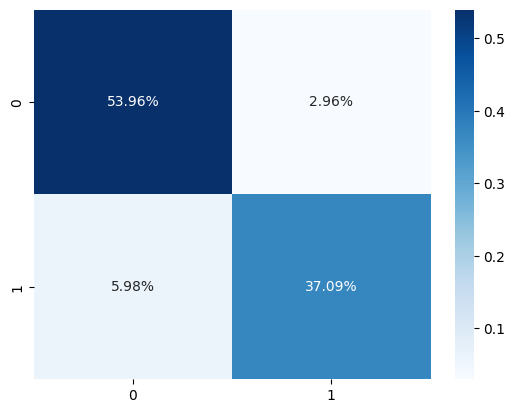

In [ ]:
confusion_matrix = metrics.confusion_matrix(target_test, y_test_pred)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
#cm_display.plot()
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

In [ ]:
results = pd.DataFrame(y_test_pred)
print(results)

       0
0      0
1      0
2      1
3      0
4      0
5      1
6      1
7      0
8      1
9      0
10     0
11     1
12     0
13     0
14     0
15     1
16     1
17     1
18     0
19     0
20     0
21     0
22     1
23     1
24     0
25     0
26     1
27     1
28     0
29     0
30     0
31     1
32     1
33     1
34     0
35     0
36     1
37     1
38     1
39     1
40     0
41     1
42     1
43     1
44     0
45     1
46     0
47     0
48     0
49     0
50     1
51     1
52     0
53     0
54     0
55     1
56     0
57     0
58     0
59     1
60     0
61     0
62     1
63     1
64     0
65     1
66     0
67     0
68     0
69     1
70     0
71     1
72     1
73     1
74     0
75     1
76     1
77     0
78     1
79     1
80     0
81     0
82     0
83     1
84     1
85     1
86     0
87     0
88     1
89     1
90     1
91     1
92     0
93     0
94     0
95     1
96     1
97     1
98     0
99     0
100    0
101    0
102    0
103    0
104    1
105    0
106    0
107    1
108    0
109    1
1

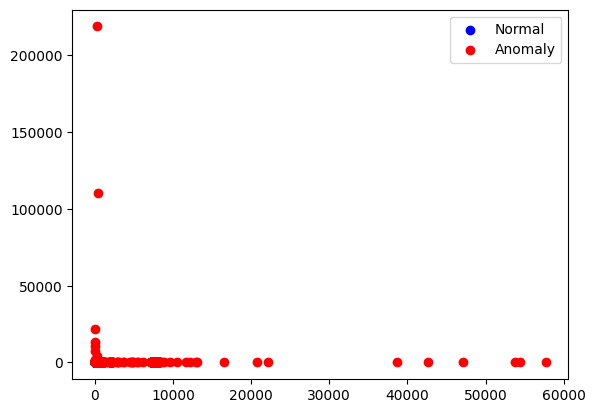

In [ ]:
#plt.figure(figsize=(50,50))
plt.figure()
#plt.ylim(0, 50)
#plt.xlim(0,1000)
plt.scatter(test.iloc[y_test_pred==1].values, test.iloc[y_test_pred==0].values, c='blue', label='Normal')
plt.scatter(test.iloc[y_test_pred==1,0].values, test.iloc[y_test_pred==1,1].values, c='red', label='Anomaly')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
